In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
import glob

# Precinct Shapefile
---
## VEST's Documentation File

Election results from the New Mexico Secretary of State's website (http://electionresults.sos.state.nm.us/).
Precinct shapefiles for most counties from the state legislature's redistricting site (https://www.nmlegis.gov/Redistricting/). Lincoln, Los Alamos, McKinley, Sandoval, and Socorro updated with VTDs released by the Census Bureau's Redistricting Data Program.

Two additional precincts added to Santa Fe's 2011 map based on a 2016 PDF.
Several precincts in Roosevelt County renumbered from the 2011 map.

* G16PRERTRU - Donald J. Trump (Republican Party)
* G16PREDCLI - Hillary Clinton (Democratic Party)
* G16PRELJOH - Gary Johnson (Libertarian Party)
* G16PREGSTE - Jill Stein (Green Party)
* G16PREIMCM - Evan McMullin (Better For America Party)
* G16PRECCAS - Darrell L. Castle (Constitution Party)
* G16PRESLAR - Gloria La Riva (Socialism and Liberation Party)
* G16PREAROC - Roque De La Fuente (American Delta Party)


* G16SOSRESP - Nora Espinoza (Republican Party)
* G16SOSDOLI - Maggie Toulouse Oliver (Democratic Party)


* G16SSCRNAK - Judith K. Nakamura (Republican Party)
* G16SSCDVIG - Michael E. Vigil (Democratic Party)


* G16SACRFRE - Stephen G. French (Republican Party)
* G16SACDVAR - Julie J. Vargas (Democratic Party)

## Load in VEST's Final File

In [2]:
vest_shp = gp.read_file("./raw-from-source/VEST/nm_2016/nm_2016.shp")

In [3]:
vest_shp.shape

(1492, 18)

In [4]:
vest_shp.head(1)

,COUNTYFP,VTDST,NAMELSAD,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,geometry
0,003,6,Catron County Precinct 6,79,20,7,2,1,1,0,0,80,31,84,26,86,23,"POLYGON Z ((-108.71685 33.98629 0.00000, -108...."


<AxesSubplot:>

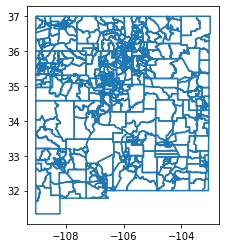

In [5]:
vest_shp.boundary.plot()

In [6]:
vest_shp.columns

Index(['COUNTYFP', 'VTDST', 'NAMELSAD', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREGSTE', 'G16PREIMCM', 'G16PRECCAS', 'G16PRESLAR',
       'G16PREAROC', 'G16SOSRESP', 'G16SOSDOLI', 'G16SSCRNAK', 'G16SSCDVIG',
       'G16SACRFRE', 'G16SACDVAR', 'geometry'],
      dtype='object')

# Election Results

## Load Files
The SOS directed to this link for election results for the 2016 general: (http://electionresults.sos.state.nm.us/) 
The updated link for 2016 general election results: (https://electionresults.sos.state.nm.us/?eid=84)

### Precinct-Level Elction Results 

In [7]:
# Open folder
folder = os.listdir("./raw-from-source/Election_Results/")

# Create an empty list to add the overall data
files = []

county_list = ['Rio Arriba', 'Catron', 'De Baca', 'San Miguel', 'Sierra', 'Sandoval', 'Eddy', 'Luna', 'Colfax', 'Torrance', 'Valencia', 'Lea', 'San Juan', 'Roosevelt', 'Hidalgo', 'McKinley', 'Santa Fe', 'Quay', 'Dona Ana', 'Guadalupe', 'Lincoln', 'Los Alamos', 'Union', 'Chaves', 'Socorro', 'Harding', 'Cibola', 'Curry', 'Otero', 'Taos', 'Bernalillo', 'Mora', 'Grant']


# Iterate over files in the folder 
for file in folder:
    # Work on precinct-level data files only
    if "Precinct" in file:
        # Create the file path
        election = pd.ExcelFile("./raw-from-source/Election_Results/" + file)
        # Set sheet names as counties (each sheet was named after the county data it contains)
        counties = election.sheet_names
        # Create an empty list to add the county data
        df_election = []
        # Iterate over all the counties
        for county in county_list: 
            # Import the file
            df = pd.read_excel(election, sheet_name = county, skiprows=[0,1,2,3,4,5])
            # Omit the empty column
            df = df.loc[:, df.columns != df.columns[0]]
            # Add the county column
            df = pd.concat([pd.Series(county, index=df.index, name='County'), df], axis=1)
            # Add the data to the list
            df_election.append(df)
        # Create each election's final dataframe
        combined_df_election = pd.concat(df_election)
        # Reset index for each election
        combined_df_election.reset_index(drop=True,inplace=True)
        # Add the election results to the overall list
        files.append(combined_df_election)
# Create the final dataframe with all election results
nm_16 = pd.concat(files, axis = 1)
nm_16

,County,Precinct,JUDITH K NAKAMURA,MICHAEL E VIGIL,County,Precinct,GARY JOHNSON AND BILL WELD,DARRELL CASTLE AND SCOTT BRADLEY,DONALD J TRUMP AND MICHAEL R PENCE,HILLARY RODHAM CLINTON AND TIMOTHY MICHAEL KAINE,...,EVAN MCMULLIN AND NATHAN JOHNSON,"""ROCKY"" ROQUE DE LA FUENTE AND MICHAEL STEINBERG",County,Precinct,STEPHEN G FRENCH,JULIE J VARGAS,County,Precinct,NORA ESPINOZA,MAGGIE TOULOUSE OLIVER
0,Rio Arriba,PREC 001,70,300,Rio Arriba,PREC 001,24,*,59,289,...,*,*,Rio Arriba,PREC 001,66,298,Rio Arriba,PREC 001,67,307
1,Rio Arriba,PREC 002,201,688,Rio Arriba,PREC 002,73,*,185,651,...,*,*,Rio Arriba,PREC 002,193,683,Rio Arriba,PREC 002,206,671
2,Rio Arriba,PREC 003,112,286,Rio Arriba,PREC 003,29,*,113,276,...,*,*,Rio Arriba,PREC 003,114,286,Rio Arriba,PREC 003,133,270
3,Rio Arriba,PREC 004,142,455,Rio Arriba,PREC 004,63,*,157,407,...,*,*,Rio Arriba,PREC 004,141,429,Rio Arriba,PREC 004,170,429
4,Rio Arriba,PREC 005,76,251,Rio Arriba,PREC 005,32,*,82,214,...,*,*,Rio Arriba,PREC 005,79,246,Rio Arriba,PREC 005,104,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,Grant,PRECINCT 032,21,116,Grant,PRECINCT 032,11,*,23,106,...,*,*,Grant,PRECINCT 032,22,113,Grant,PRECINCT 032,28,109
1521,Grant,PRECINCT 033,170,142,Grant,PRECINCT 033,20,*,179,116,...,*,*,Grant,PRECINCT 033,167,142,Grant,PRECINCT 033,157,159
1522,Grant,PRECINCT 034,61,241,Grant,PRECINCT 034,24,*,72,218,...,*,*,Grant,PRECINCT 034,57,240,Grant,PRECINCT 034,67,232
1523,Grant,PRECINCT 035,52,11,Grant,PRECINCT 035,8,*,49,7,...,*,*,Grant,PRECINCT 035,50,11,Grant,PRECINCT 035,41,23


### County-Level Election Results

In [8]:
# Open folder
folder = os.listdir("./raw-from-source/Election_Results/")

# Create an empty list to add the overall data
files = []

# Iterate over files in the folder 
for file in folder:
    # Work on precinct-level data files only
    if "County" in file:
        # Create the file path
        election = pd.ExcelFile("./raw-from-source/Election_Results/" + file)
        # Import the file
        df = pd.read_excel(election, skiprows=[0,1,2,3,4,5])
        # Omit the empty column
        df = df.loc[:, df.columns != df.columns[0]]
        # Add the election results to the overall list
        files.append(df)
# Create the final dataframe with all election results
nm_16_county = pd.concat(files, axis = 1)

nm_16_county

,County,JUDITH K NAKAMURA,MICHAEL E VIGIL,County,STEPHEN G FRENCH,JULIE J VARGAS,County,NORA ESPINOZA,MAGGIE TOULOUSE OLIVER,County,GARY JOHNSON AND BILL WELD,DARRELL CASTLE AND SCOTT BRADLEY,DONALD J TRUMP AND MICHAEL R PENCE,HILLARY RODHAM CLINTON AND TIMOTHY MICHAEL KAINE,JILL STEIN AND AJAMU BARAKA,GLORIA LA RIVA AND DENNIS BANKS,EVAN MCMULLIN AND NATHAN JOHNSON,"""ROCKY"" ROQUE DE LA FUENTE AND MICHAEL STEINBERG"
0,Bernalillo,143163,118924,Bernalillo,118163,140046,Bernalillo,98628,165274,Bernalillo,29682,474,94698,143417,3614,445,2181,151
1,Catron,1409,513,Catron,1373,525,Catron,1355,599,Catron,111,12,1464,427,23,*,11,*
2,Chaves,13066,6483,Chaves,13215,6274,Chaves,13233,6583,Chaves,1609,32,12872,5534,86,22,102,14
3,Cibola,3590,4079,Cibola,3130,4482,Cibola,3133,4614,Cibola,970,16,3195,3741,73,20,43,5
4,Colfax,2803,2306,Colfax,2675,2423,Colfax,2478,2683,Colfax,527,12,2585,2129,37,5,31,6
5,Curry,8762,3885,Curry,8770,3820,Curry,8720,4051,Curry,973,39,9035,3121,74,10,112,6
6,De Baca,551,281,De Baca,544,271,De Baca,529,320,De Baca,89,*,620,193,6,*,*,*
7,Dona Ana,30197,37699,Dona Ana,27757,39701,Dona Ana,30109,37753,Dona Ana,5471,157,25374,37947,953,115,566,65
8,Eddy,12492,6042,Eddy,12496,5908,Eddy,12634,6150,Eddy,1275,27,13147,5033,84,12,83,6
9,Grant,5446,6793,Grant,5283,6846,Grant,5109,7246,Grant,899,25,5288,6276,218,19,80,6


## Clean up the Election Results
The precinct-level election results provided by New Mexico SOS contained multiple missing values. The vote numbers were replaced with *. In our validation process, * values were replaced with 0 to continue the validation process. New Mexico SOS was notified of this issue.

### Precinct-Level Election Results

In [9]:
# Rename the columns to match VEST
nm_16 = nm_16.rename(columns = {'GARY JOHNSON AND BILL WELD':'G16PRELJOH',
       'DARRELL CASTLE AND SCOTT BRADLEY':'G16PRECCAS',
       'DONALD J TRUMP AND MICHAEL R PENCE':'G16PRERTRU',
       'HILLARY RODHAM CLINTON AND TIMOTHY MICHAEL KAINE':'G16PREDCLI',
       'JILL STEIN AND AJAMU BARAKA':'G16PREGSTE', 'GLORIA LA RIVA AND DENNIS BANKS':'G16PRESLAR',
       'EVAN MCMULLIN AND NATHAN JOHNSON':'G16PREIMCM',
       '"ROCKY" ROQUE DE LA FUENTE AND MICHAEL STEINBERG':'G16PREAROC', 'STEPHEN G FRENCH':'G16SACRFRE',
       'JULIE J VARGAS':'G16SACDVAR', 'NORA ESPINOZA':'G16SOSRESP', 'MAGGIE TOULOUSE OLIVER':'G16SOSDOLI',
       'JUDITH K NAKAMURA':'G16SSCRNAK', 'MICHAEL E VIGIL':'G16SSCDVIG'})

# Reorder the columns to match VEST
nm_16 = nm_16[['County','Precinct','G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PREGSTE','G16PREIMCM',
               'G16PRECCAS','G16PRESLAR','G16PREAROC','G16SOSRESP','G16SOSDOLI','G16SSCRNAK','G16SSCDVIG',
               'G16SACRFRE','G16SACDVAR']]

# Remove duplicate columns
nm_16 = nm_16.loc[:,~nm_16.columns.duplicated()]

# Remove the rows with Total votes
nm_16 = nm_16[nm_16["Precinct"]!="TOTALS"]

# Fill n/a values with 0 and * values with 0
nm_16 = nm_16.fillna(0)
nm_16 = nm_16.replace(to_replace="*", value = 0)

# Display results in alphabetical order of the counties
nm_16 = nm_16.sort_values(by = ['County', 'Precinct'], ascending = True)

# Change strings to integers (County and Precinct columns remain unchanged)
nm_16 = nm_16.apply(pd.to_numeric, errors='ignore')

# Deal with the index 
nm_16.reset_index(drop=True,inplace=True)


In [10]:
nm_16

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR
0,Bernalillo,PCT 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336
1,Bernalillo,PCT 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259
2,Bernalillo,PCT 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384
3,Bernalillo,PCT 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250
4,Bernalillo,PCT 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,PRECINCT 37,187,135,32,0,0,0,0,0,177,176,203,145,188,154
1488,Valencia,PRECINCT 38,306,221,59,0,0,0,0,0,302,277,349,227,321,253
1489,Valencia,PRECINCT 39,652,518,106,11,13,0,0,0,659,613,751,514,689,569
1490,Valencia,PRECINCT 40,387,335,82,7,6,0,0,0,371,437,447,354,403,390


### County Level Election Results

In [11]:
# Rename the columns to match VEST
nm_16_county = nm_16_county.rename(columns = {'GARY JOHNSON AND BILL WELD':'G16PRELJOH',
       'DARRELL CASTLE AND SCOTT BRADLEY':'G16PRECCAS',
       'DONALD J TRUMP AND MICHAEL R PENCE':'G16PRERTRU',
       'HILLARY RODHAM CLINTON AND TIMOTHY MICHAEL KAINE':'G16PREDCLI',
       'JILL STEIN AND AJAMU BARAKA':'G16PREGSTE', 'GLORIA LA RIVA AND DENNIS BANKS':'G16PRESLAR',
       'EVAN MCMULLIN AND NATHAN JOHNSON':'G16PREIMCM',
       '"ROCKY" ROQUE DE LA FUENTE AND MICHAEL STEINBERG':'G16PREAROC', 'STEPHEN G FRENCH':'G16SACRFRE',
       'JULIE J VARGAS':'G16SACDVAR', 'NORA ESPINOZA':'G16SOSRESP', 'MAGGIE TOULOUSE OLIVER':'G16SOSDOLI',
       'JUDITH K NAKAMURA':'G16SSCRNAK', 'MICHAEL E VIGIL':'G16SSCDVIG'})

# Reorder the columns to match VEST
nm_16_county = nm_16_county[['County','G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PREGSTE','G16PREIMCM',
               'G16PRECCAS','G16PRESLAR','G16PREAROC','G16SOSRESP','G16SOSDOLI','G16SSCRNAK','G16SSCDVIG',
               'G16SACRFRE','G16SACDVAR']]

# Remove duplicate columns
nm_16_county = nm_16_county.loc[:,~nm_16_county.columns.duplicated()]

# Remove the rows with Total votes
nm_16_county = nm_16_county[nm_16_county["County"]!="TOTALS"]

# Fill n/a values and * values with 2 (average of the numbers between 0 and 4)
nm_16_county = nm_16_county.fillna(0)
nm_16_county = nm_16_county.replace(to_replace="*", value = 2)

# Display results in alphabetical order of the counties
nm_16_county = nm_16_county.sort_values(by = ['County'], ascending = True)

# Change strings to integers (County and Precinct columns remain unchanged)
nm_16_county = nm_16_county.apply(pd.to_numeric, errors='ignore')

# Deal with the index 
nm_16_county.reset_index(drop=True,inplace=True)

## Validate the Election Results

### Check Statewide Candidate Totals

In [12]:
data_columns = ['G16PRERTRU','G16PREDCLI','G16PRELJOH','G16PREGSTE','G16PREIMCM',
               'G16PRECCAS','G16PRESLAR','G16PREAROC','G16SOSRESP','G16SOSDOLI','G16SSCRNAK','G16SSCDVIG',
               'G16SACRFRE','G16SACDVAR']
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [13]:
statewide_totals_check(vest_shp,nm_16,data_columns)

***Statewide Totals Check***
G16PRERTRU has a difference of 29 votes
	VEST: 319667 votes
	SOURCES: 319638 votes
G16PREDCLI has a difference of 71 votes
	VEST: 385234 votes
	SOURCES: 385163 votes
G16PRELJOH has a difference of 139 votes
	VEST: 74541 votes
	SOURCES: 74402 votes
G16PREGSTE has a difference of 1848 votes
	VEST: 9879 votes
	SOURCES: 8031 votes
G16PREIMCM has a difference of 1988 votes
	VEST: 5825 votes
	SOURCES: 3837 votes
G16PRECCAS has a difference of 1355 votes
	VEST: 1514 votes
	SOURCES: 159 votes
G16PRESLAR has a difference of 1099 votes
	VEST: 1184 votes
	SOURCES: 85 votes
G16PREAROC has a difference of 475 votes
	VEST: 475 votes
	SOURCES: 0 votes
G16SOSRESP has a difference of 13 votes
	VEST: 334733 votes
	SOURCES: 334720 votes
G16SOSDOLI has a difference of 34 votes
	VEST: 433227 votes
	SOURCES: 433193 votes
G16SSCRNAK has a difference of 9 votes
	VEST: 396303 votes
	SOURCES: 396294 votes
G16SSCDVIG has a difference of 37 votes
	VEST: 365790 votes
	SOURCES: 365753 v

### Check County Totals

#### Add in County FIPs Data to Precinct-Level Election Results

In [14]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
NM_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
county_name_changes_dict = {"McKinley":"Mckinley"}
nm_16["COUNTYFP"] = nm_16["County"].map(county_name_changes_dict).fillna(nm_16["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_16["COUNTYFP"] = nm_16["COUNTYFP"].map(NM_fips_dict).fillna(nm_16["COUNTYFP"])

print(nm_16["COUNTYFP"].unique())

# Check the number of counties - looking for 33
print(len(nm_16["COUNTYFP"].unique()))

['001' '003' '005' '006' '007' '009' '011' '013' '015' '017' '019' '021'
 '023' '025' '027' '028' '029' '031' '033' '035' '037' '039' '041' '045'
 '047' '043' '049' '051' '053' '055' '057' '059' '061']
33


#### Add in County FIPs Data to Precinct-Level Election Results

In [15]:
# Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="New Mexico"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

# Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

# Create the dictionary
NM_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

# Modify county names in dataframe to match the FIPs file
# county_name_changes_dict = {"McKinley":"Mckinley"}
nm_16_county["COUNTYFP"] = nm_16_county["County"].map(county_name_changes_dict).fillna(nm_16_county["County"])

# Use the dictionary to go from a county name to a county FIPS
nm_16_county["COUNTYFP"] = nm_16_county["COUNTYFP"].map(NM_fips_dict).fillna(nm_16_county["COUNTYFP"])

print(nm_16_county["COUNTYFP"].unique())

# Check the number of counties - looking for 33
print(len(nm_16_county["COUNTYFP"].unique()))

['001' '003' '005' '006' '007' '009' '011' '013' '015' '017' '019' '021'
 '023' '025' '027' '028' '029' '031' '033' '035' '037' '039' '041' '045'
 '047' '043' '049' '051' '053' '055' '057' '059' '061']
33


#### Check the Results

In [16]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [17]:
county_totals_check(vest_shp,nm_16,data_columns,"COUNTYFP", full_print=False)

***Countywide Totals Check***

G16PRERTRU contains differences in these counties:
	006 has a difference of 5 votes
		VEST: 3195 votes
		SOURCES: 3190 votes
	039 has a difference of 5 votes
		VEST: 3599 votes
		SOURCES: 3594 votes
	049 has a difference of 3 votes
		VEST: 14332 votes
		SOURCES: 14329 votes
	053 has a difference of 8 votes
		VEST: 2616 votes
		SOURCES: 2608 votes
	055 has a difference of 8 votes
		VEST: 2727 votes
		SOURCES: 2719 votes
G16PREDCLI contains differences in these counties:
	005 has a difference of 4 votes
		VEST: 5534 votes
		SOURCES: 5530 votes
	009 has a difference of 7 votes
		VEST: 3121 votes
		SOURCES: 3114 votes
	015 has a difference of 8 votes
		VEST: 5033 votes
		SOURCES: 5025 votes
	017 has a difference of 5 votes
		VEST: 6276 votes
		SOURCES: 6271 votes
	025 has a difference of 2 votes
		VEST: 3930 votes
		SOURCES: 3928 votes
	035 has a difference of 11 votes
		VEST: 6124 votes
		SOURCES: 6113 votes
	037 has a difference of 6 votes
		VEST: 1017 vote

		VEST: 29 votes
		SOURCES: 0 votes
	029 has a difference of 13 votes
		VEST: 13 votes
		SOURCES: 0 votes
	031 has a difference of 52 votes
		VEST: 58 votes
		SOURCES: 6 votes
	033 has a difference of 4 votes
		VEST: 4 votes
		SOURCES: 0 votes
	035 has a difference of 60 votes
		VEST: 67 votes
		SOURCES: 7 votes
	037 has a difference of 8 votes
		VEST: 8 votes
		SOURCES: 0 votes
	039 has a difference of 17 votes
		VEST: 17 votes
		SOURCES: 0 votes
	041 has a difference of 11 votes
		VEST: 11 votes
		SOURCES: 0 votes
	043 has a difference of 105 votes
		VEST: 129 votes
		SOURCES: 24 votes
	045 has a difference of 113 votes
		VEST: 125 votes
		SOURCES: 12 votes
	047 has a difference of 19 votes
		VEST: 25 votes
		SOURCES: 6 votes
	049 has a difference of 68 votes
		VEST: 75 votes
		SOURCES: 7 votes
	051 has a difference of 12 votes
		VEST: 12 votes
		SOURCES: 0 votes
	053 has a difference of 15 votes
		VEST: 15 votes
		SOURCES: 0 votes
	055 has a difference of 6 votes
		VEST: 6 votes
		S

In [18]:
county_totals_check(vest_shp,nm_16_county,data_columns,"COUNTYFP",full_print=False)

***Countywide Totals Check***

G16PRERTRU is equal across all counties
G16PREDCLI is equal across all counties
G16PRELJOH is equal across all counties
G16PREGSTE contains differences in these counties:
	021 has a difference of 1 votes
		VEST: 3 votes
		SOURCES: 2 votes
G16PREIMCM contains differences in these counties:
	021 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
G16PRECCAS contains differences in these counties:
	011 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
	019 has a difference of -1 votes
		VEST: 1 votes
		SOURCES: 2 votes
	033 has a difference of 2 votes
		VEST: 4 votes
		SOURCES: 2 votes
G16PRESLAR contains differences in these counties:
	003 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
	011 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
	019 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
	021 has a difference of -2 votes
		VEST: 0 votes
		SOURCES: 2 votes
	023 has a difference of 1

### Check Precinct Votes 

The precinct name column in the SOS precinct-level election results file and the VEST file have been compared before joining. Minor changes to the precinct names have been made to match the format of the precinct name. 

#### Precinct Name Column Change in Election Results File

In [19]:
# Change PCT and PREC in election results' precinct name column to spell out Precinct
nm_16['Precinct'] = nm_16.Precinct.replace({'PCT':'Precinct', 'PREC ':'Precinct '}, regex = True)

nm_16

,County,Precinct,G16PRERTRU,G16PREDCLI,G16PRELJOH,G16PREGSTE,G16PREIMCM,G16PRECCAS,G16PRESLAR,G16PREAROC,G16SOSRESP,G16SOSDOLI,G16SSCRNAK,G16SSCDVIG,G16SACRFRE,G16SACDVAR,COUNTYFP
0,Bernalillo,Precinct 001,311,346,61,9,6,0,0,0,299,389,391,302,348,336,001
1,Bernalillo,Precinct 002,270,288,52,0,11,0,0,0,275,330,387,215,329,259,001
2,Bernalillo,Precinct 003,352,381,86,20,9,0,0,0,363,451,492,328,428,384,001
3,Bernalillo,Precinct 004,202,290,66,7,7,0,0,0,219,342,337,216,296,250,001
4,Bernalillo,Precinct 005,183,302,35,0,0,0,0,0,173,338,287,222,224,276,001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,Valencia,PRECINCT 37,187,135,32,0,0,0,0,0,177,176,203,145,188,154,061
1488,Valencia,PRECINCT 38,306,221,59,0,0,0,0,0,302,277,349,227,321,253,061
1489,Valencia,PRECINCT 39,652,518,106,11,13,0,0,0,659,613,751,514,689,569,061
1490,Valencia,PRECINCT 40,387,335,82,7,6,0,0,0,371,437,447,354,403,390,061


In [20]:
# Make a list of counties that contains two-digit precinct numbers
add_digit_counties = ['De Baca', 'Eddy', 'Guadalupe', 'Hidalgo', 'Los Alamos', 'McKinley', 'Otero', 'San Juan', 'Valencia']

# Create a dataframe containing only the data of precincts with two-digit precinct numbers
new_df = nm_16[nm_16['County'].isin(add_digit_counties)]

# Delete the string 'Precinct' to work with numbers
new_df['Precinct'] = new_df['Precinct'].str[9:]
# Turn two digit precinct numbers into three digit numbers
new_df['Precinct'] = new_df['Precinct'].str.zfill(3)
# Add back the string 'Precinct' to the precint numbers
new_df['Precinct'] = 'Precinct ' + new_df['Precinct'].astype(str)

# Select the counties with two digit county numbers in the original dataframe
i = nm_16[nm_16['County'].isin(add_digit_counties)].index
# Remove the counties with two digit county numbers from the original dataframe
nm_16 = nm_16.drop(i)
# Add in the counties that originally had two digit county numbers (now has three digits) to the original dataframe
nm_16 = pd.concat([nm_16, new_df], ignore_index = True)

<ipython-input-20-f50072bbd09b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Precinct'] = new_df['Precinct'].str[9:]
<ipython-input-20-f50072bbd09b>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Precinct'] = new_df['Precinct'].str.zfill(3)
<ipython-input-20-f50072bbd09b>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [21]:
# Create a dataframe containing only the Colfax County's data
number_precinct_check = nm_16[nm_16["County"]=="Colfax"]
# Add the string 'Precinct' to the Colfax county's precinct names
number_precinct_check['Precinct'] = 'Precinct ' + number_precinct_check['Precinct'].astype(str)

# Select the rows containing Colfax County data from the original dataframe
j = nm_16[(nm_16.County == 'Colfax')].index
# Remove the Colfax County data from the original dataframe
nm_16 = nm_16.drop(j)

# Add in the changed Colfax County data
nm_16 = pd.concat([nm_16, number_precinct_check], ignore_index = True)

# Display results in alphabetical order of the counties
nm_16 = nm_16.sort_values(by = ['County', 'Precinct'], ascending = True)

# Deal with the index 
nm_16.reset_index(drop=True,inplace=True)

<ipython-input-21-c561eb5fe252>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  number_precinct_check['Precinct'] = 'Precinct ' + number_precinct_check['Precinct'].astype(str)


#### Precinct Name Column Change in VEST File

In [22]:
# Create an one time ID to refer back to
vest_shp['One_Time_ID'] = vest_shp["COUNTYFP"]+"-"+vest_shp['NAMELSAD']

# Extract only the precinct number portion of the NAMELSAD column and add the data in the new column 'Number'
vest_shp['Number'] = vest_shp['NAMELSAD'].str.extract('(\d+\.?\d*)', expand = True)
# Change the one-digit and two-digit precinct numbers to three digit precinct numbers
vest_shp['Number'] = vest_shp['Number'].str.zfill(3)

In [23]:
# Delete the string that comes after 'Precinct' in the NAMELSAD column 
vest_shp['NAMELSAD'] = vest_shp['NAMELSAD'].str.split('Precinct').str[0]

In [24]:
# Add the string 'Precinct' and the three digit precint number to the NAMELSAD column
vest_shp['NAMELSAD'] = vest_shp['NAMELSAD']+'Precinct '+vest_shp['Number']

# Remove One_Time_ID column and Number column
vest_shp = vest_shp.drop(columns = ['One_Time_ID','Number'])

# Display results in alphabetical order of the counties
vest_shp = vest_shp.sort_values(by = ['COUNTYFP', 'NAMELSAD'], ascending = True)

# Replace empty space
vest_shp.columns = vest_shp.columns.str.replace(' ', '')
vest_shp.columns = vest_shp.columns.str.rstrip()

# Deal with the index 
vest_shp.reset_index(drop=True,inplace=True)

#### Create a 'join_col' in Both Files

In [25]:
# Create a VEST join col
vest_shp["join_col"] = vest_shp["COUNTYFP"]+"-"+vest_shp['NAMELSAD']
# Check to make sure it is unique
print(vest_shp["join_col"].value_counts(dropna=False))

# Create an election results join col
nm_16["join_col"] = nm_16["COUNTYFP"]+"-"+nm_16["County"]+" County "+nm_16["Precinct"]
# Check to make sure it is unique
print(nm_16["join_col"].value_counts(dropna=False))

045-San Juan County Precinct 043      1
061-Valencia County Precinct 022      1
019-Guadalupe County Precinct 002     1
001-Bernalillo County Precinct 300    1
049-Santa Fe County Precinct 084      1
                                     ..
001-Bernalillo County Precinct 551    1
055-Taos County Precinct 023          1
001-Bernalillo County Precinct 193    1
045-San Juan County Precinct 031      1
057-Torrance County Precinct 012      1
Name: join_col, Length: 1492, dtype: int64
013-Dona Ana County Precinct 078      1
045-San Juan County Precinct 034      1
019-Guadalupe County Precinct 002     1
001-Bernalillo County Precinct 300    1
005-Chaves County PRECINCT 035        1
                                     ..
013-Dona Ana County Precinct 066      1
013-Dona Ana County Precinct 060      1
061-Valencia County Precinct 029      1
037-Quay County PRECINCT 011          1
025-Lea County PRECINCT 027           1
Name: join_col, Length: 1492, dtype: int64


In [26]:
# Make sure the join_col in both files is unique
print(len(nm_16["join_col"]))
print(nm_16["join_col"].value_counts().sum())

print(len(vest_shp["join_col"]))
print(vest_shp["join_col"].value_counts().sum())

1492
1492
1492
1492


In [27]:
# Uppercase both join columns
nm_16['join_col'] = nm_16['join_col'].str.upper()
vest_shp['join_col'] = vest_shp['join_col'].str.upper()

# Strip white space
nm_16['join_col'] = nm_16['join_col'].str.strip()
vest_shp['join_col']=vest_shp['join_col'].str.strip()

#### First Join Attempt

In [28]:
join_attempt_one = pd.merge(vest_shp,nm_16,how="outer",on="join_col",indicator=True)
join_attempt_one["_merge"].value_counts()

both          1365
left_only      127
right_only     127
Name: _merge, dtype: int64

#### Look into Unjoined Precincts

In [29]:
# join_attempt_one[join_attempt_one["_merge"] == "left_only"]['join_col'].to_csv("./vest_only.csv")
# join_attempt_one[join_attempt_one["_merge"] == "right_only"]['join_col'].to_csv("./election_only.csv")

In [30]:
# Create a list containing VEST's join_col values
vest_ID = list(join_attempt_one[join_attempt_one["_merge"] == "left_only"]['join_col'].to_dict().values())

In [31]:
# Create a list containing election results' join_col values
election_ID = list(join_attempt_one[join_attempt_one["_merge"] == "right_only"]['join_col'].to_dict().values())

In [32]:
# Create an empty dictionary
res = {}

# for each value in election results list
for eid in election_ID:
    # and for each value in vest results list
    for vid in vest_ID:
        # add the value to the dictionary in the "(election results value):(vest results value)" form
        res[eid] = vid
        vest_ID.remove(vid)
        break
        
print(str(res))

{'013-DONA ANA COUNTY PRECINCT 001': '013-DOÑA ANA COUNTY PRECINCT 001', '013-DONA ANA COUNTY PRECINCT 002': '013-DOÑA ANA COUNTY PRECINCT 002', '013-DONA ANA COUNTY PRECINCT 003': '013-DOÑA ANA COUNTY PRECINCT 003', '013-DONA ANA COUNTY PRECINCT 004': '013-DOÑA ANA COUNTY PRECINCT 004', '013-DONA ANA COUNTY PRECINCT 005': '013-DOÑA ANA COUNTY PRECINCT 005', '013-DONA ANA COUNTY PRECINCT 006': '013-DOÑA ANA COUNTY PRECINCT 006', '013-DONA ANA COUNTY PRECINCT 007': '013-DOÑA ANA COUNTY PRECINCT 007', '013-DONA ANA COUNTY PRECINCT 008': '013-DOÑA ANA COUNTY PRECINCT 008', '013-DONA ANA COUNTY PRECINCT 009': '013-DOÑA ANA COUNTY PRECINCT 009', '013-DONA ANA COUNTY PRECINCT 010': '013-DOÑA ANA COUNTY PRECINCT 010', '013-DONA ANA COUNTY PRECINCT 011': '013-DOÑA ANA COUNTY PRECINCT 011', '013-DONA ANA COUNTY PRECINCT 012': '013-DOÑA ANA COUNTY PRECINCT 012', '013-DONA ANA COUNTY PRECINCT 013': '013-DOÑA ANA COUNTY PRECINCT 013', '013-DONA ANA COUNTY PRECINCT 014': '013-DOÑA ANA COUNTY PRECIN

#### Change Names to Perform Join
Note: VEST had misspelled Sandoval County for Precinct 76

In [33]:
election_vest_id_changes_dict = {'013-DONA ANA COUNTY PRECINCT 001': '013-DOÑA ANA COUNTY PRECINCT 001', '013-DONA ANA COUNTY PRECINCT 002': '013-DOÑA ANA COUNTY PRECINCT 002', '013-DONA ANA COUNTY PRECINCT 003': '013-DOÑA ANA COUNTY PRECINCT 003', '013-DONA ANA COUNTY PRECINCT 004': '013-DOÑA ANA COUNTY PRECINCT 004', '013-DONA ANA COUNTY PRECINCT 005': '013-DOÑA ANA COUNTY PRECINCT 005', '013-DONA ANA COUNTY PRECINCT 006': '013-DOÑA ANA COUNTY PRECINCT 006', '013-DONA ANA COUNTY PRECINCT 007': '013-DOÑA ANA COUNTY PRECINCT 007', '013-DONA ANA COUNTY PRECINCT 008': '013-DOÑA ANA COUNTY PRECINCT 008', '013-DONA ANA COUNTY PRECINCT 009': '013-DOÑA ANA COUNTY PRECINCT 009', '013-DONA ANA COUNTY PRECINCT 010': '013-DOÑA ANA COUNTY PRECINCT 010', '013-DONA ANA COUNTY PRECINCT 011': '013-DOÑA ANA COUNTY PRECINCT 011', '013-DONA ANA COUNTY PRECINCT 012': '013-DOÑA ANA COUNTY PRECINCT 012', '013-DONA ANA COUNTY PRECINCT 013': '013-DOÑA ANA COUNTY PRECINCT 013', '013-DONA ANA COUNTY PRECINCT 014': '013-DOÑA ANA COUNTY PRECINCT 014', '013-DONA ANA COUNTY PRECINCT 015': '013-DOÑA ANA COUNTY PRECINCT 015', '013-DONA ANA COUNTY PRECINCT 016': '013-DOÑA ANA COUNTY PRECINCT 016', '013-DONA ANA COUNTY PRECINCT 017': '013-DOÑA ANA COUNTY PRECINCT 017', '013-DONA ANA COUNTY PRECINCT 018': '013-DOÑA ANA COUNTY PRECINCT 018', '013-DONA ANA COUNTY PRECINCT 019': '013-DOÑA ANA COUNTY PRECINCT 019', '013-DONA ANA COUNTY PRECINCT 020': '013-DOÑA ANA COUNTY PRECINCT 020', '013-DONA ANA COUNTY PRECINCT 021': '013-DOÑA ANA COUNTY PRECINCT 021', '013-DONA ANA COUNTY PRECINCT 022': '013-DOÑA ANA COUNTY PRECINCT 022', '013-DONA ANA COUNTY PRECINCT 023': '013-DOÑA ANA COUNTY PRECINCT 023', '013-DONA ANA COUNTY PRECINCT 024': '013-DOÑA ANA COUNTY PRECINCT 024', '013-DONA ANA COUNTY PRECINCT 025': '013-DOÑA ANA COUNTY PRECINCT 025', '013-DONA ANA COUNTY PRECINCT 026': '013-DOÑA ANA COUNTY PRECINCT 026', '013-DONA ANA COUNTY PRECINCT 027': '013-DOÑA ANA COUNTY PRECINCT 027', '013-DONA ANA COUNTY PRECINCT 028': '013-DOÑA ANA COUNTY PRECINCT 028', '013-DONA ANA COUNTY PRECINCT 029': '013-DOÑA ANA COUNTY PRECINCT 029', '013-DONA ANA COUNTY PRECINCT 030': '013-DOÑA ANA COUNTY PRECINCT 030', '013-DONA ANA COUNTY PRECINCT 031': '013-DOÑA ANA COUNTY PRECINCT 031', '013-DONA ANA COUNTY PRECINCT 032': '013-DOÑA ANA COUNTY PRECINCT 032', '013-DONA ANA COUNTY PRECINCT 033': '013-DOÑA ANA COUNTY PRECINCT 033', '013-DONA ANA COUNTY PRECINCT 034': '013-DOÑA ANA COUNTY PRECINCT 034', '013-DONA ANA COUNTY PRECINCT 035': '013-DOÑA ANA COUNTY PRECINCT 035', '013-DONA ANA COUNTY PRECINCT 036': '013-DOÑA ANA COUNTY PRECINCT 036', '013-DONA ANA COUNTY PRECINCT 037': '013-DOÑA ANA COUNTY PRECINCT 037', '013-DONA ANA COUNTY PRECINCT 038': '013-DOÑA ANA COUNTY PRECINCT 038', '013-DONA ANA COUNTY PRECINCT 039': '013-DOÑA ANA COUNTY PRECINCT 039', '013-DONA ANA COUNTY PRECINCT 040': '013-DOÑA ANA COUNTY PRECINCT 040', '013-DONA ANA COUNTY PRECINCT 041': '013-DOÑA ANA COUNTY PRECINCT 041', '013-DONA ANA COUNTY PRECINCT 042': '013-DOÑA ANA COUNTY PRECINCT 042', '013-DONA ANA COUNTY PRECINCT 043': '013-DOÑA ANA COUNTY PRECINCT 043', '013-DONA ANA COUNTY PRECINCT 044': '013-DOÑA ANA COUNTY PRECINCT 044', '013-DONA ANA COUNTY PRECINCT 045': '013-DOÑA ANA COUNTY PRECINCT 045', '013-DONA ANA COUNTY PRECINCT 046': '013-DOÑA ANA COUNTY PRECINCT 046', '013-DONA ANA COUNTY PRECINCT 047': '013-DOÑA ANA COUNTY PRECINCT 047', '013-DONA ANA COUNTY PRECINCT 048': '013-DOÑA ANA COUNTY PRECINCT 048', '013-DONA ANA COUNTY PRECINCT 049': '013-DOÑA ANA COUNTY PRECINCT 049', '013-DONA ANA COUNTY PRECINCT 050': '013-DOÑA ANA COUNTY PRECINCT 050', '013-DONA ANA COUNTY PRECINCT 051': '013-DOÑA ANA COUNTY PRECINCT 051', '013-DONA ANA COUNTY PRECINCT 052': '013-DOÑA ANA COUNTY PRECINCT 052', '013-DONA ANA COUNTY PRECINCT 053': '013-DOÑA ANA COUNTY PRECINCT 053', '013-DONA ANA COUNTY PRECINCT 054': '013-DOÑA ANA COUNTY PRECINCT 054', '013-DONA ANA COUNTY PRECINCT 055': '013-DOÑA ANA COUNTY PRECINCT 055', '013-DONA ANA COUNTY PRECINCT 056': '013-DOÑA ANA COUNTY PRECINCT 056', '013-DONA ANA COUNTY PRECINCT 057': '013-DOÑA ANA COUNTY PRECINCT 057', '013-DONA ANA COUNTY PRECINCT 058': '013-DOÑA ANA COUNTY PRECINCT 058', '013-DONA ANA COUNTY PRECINCT 059': '013-DOÑA ANA COUNTY PRECINCT 059', '013-DONA ANA COUNTY PRECINCT 060': '013-DOÑA ANA COUNTY PRECINCT 060', '013-DONA ANA COUNTY PRECINCT 061': '013-DOÑA ANA COUNTY PRECINCT 061', '013-DONA ANA COUNTY PRECINCT 062': '013-DOÑA ANA COUNTY PRECINCT 062', '013-DONA ANA COUNTY PRECINCT 063': '013-DOÑA ANA COUNTY PRECINCT 063', '013-DONA ANA COUNTY PRECINCT 064': '013-DOÑA ANA COUNTY PRECINCT 064', '013-DONA ANA COUNTY PRECINCT 065': '013-DOÑA ANA COUNTY PRECINCT 065', '013-DONA ANA COUNTY PRECINCT 066': '013-DOÑA ANA COUNTY PRECINCT 066', '013-DONA ANA COUNTY PRECINCT 067': '013-DOÑA ANA COUNTY PRECINCT 067', '013-DONA ANA COUNTY PRECINCT 068': '013-DOÑA ANA COUNTY PRECINCT 068', '013-DONA ANA COUNTY PRECINCT 069': '013-DOÑA ANA COUNTY PRECINCT 069', '013-DONA ANA COUNTY PRECINCT 070': '013-DOÑA ANA COUNTY PRECINCT 070', '013-DONA ANA COUNTY PRECINCT 071': '013-DOÑA ANA COUNTY PRECINCT 071', '013-DONA ANA COUNTY PRECINCT 072': '013-DOÑA ANA COUNTY PRECINCT 072', '013-DONA ANA COUNTY PRECINCT 073': '013-DOÑA ANA COUNTY PRECINCT 073', '013-DONA ANA COUNTY PRECINCT 074': '013-DOÑA ANA COUNTY PRECINCT 074', '013-DONA ANA COUNTY PRECINCT 075': '013-DOÑA ANA COUNTY PRECINCT 075', '013-DONA ANA COUNTY PRECINCT 076': '013-DOÑA ANA COUNTY PRECINCT 076', '013-DONA ANA COUNTY PRECINCT 077': '013-DOÑA ANA COUNTY PRECINCT 077', '013-DONA ANA COUNTY PRECINCT 078': '013-DOÑA ANA COUNTY PRECINCT 078', '013-DONA ANA COUNTY PRECINCT 079': '013-DOÑA ANA COUNTY PRECINCT 079', '013-DONA ANA COUNTY PRECINCT 080': '013-DOÑA ANA COUNTY PRECINCT 080', '013-DONA ANA COUNTY PRECINCT 081': '013-DOÑA ANA COUNTY PRECINCT 081', '013-DONA ANA COUNTY PRECINCT 082': '013-DOÑA ANA COUNTY PRECINCT 082', '013-DONA ANA COUNTY PRECINCT 083': '013-DOÑA ANA COUNTY PRECINCT 083', '013-DONA ANA COUNTY PRECINCT 084': '013-DOÑA ANA COUNTY PRECINCT 084', '013-DONA ANA COUNTY PRECINCT 085': '013-DOÑA ANA COUNTY PRECINCT 085', '013-DONA ANA COUNTY PRECINCT 086': '013-DOÑA ANA COUNTY PRECINCT 086', '013-DONA ANA COUNTY PRECINCT 087': '013-DOÑA ANA COUNTY PRECINCT 087', '013-DONA ANA COUNTY PRECINCT 088': '013-DOÑA ANA COUNTY PRECINCT 088', '013-DONA ANA COUNTY PRECINCT 089': '013-DOÑA ANA COUNTY PRECINCT 089', '013-DONA ANA COUNTY PRECINCT 090': '013-DOÑA ANA COUNTY PRECINCT 090', '013-DONA ANA COUNTY PRECINCT 091': '013-DOÑA ANA COUNTY PRECINCT 091', '013-DONA ANA COUNTY PRECINCT 092': '013-DOÑA ANA COUNTY PRECINCT 092', '013-DONA ANA COUNTY PRECINCT 093': '013-DOÑA ANA COUNTY PRECINCT 093', '013-DONA ANA COUNTY PRECINCT 094': '013-DOÑA ANA COUNTY PRECINCT 094', '013-DONA ANA COUNTY PRECINCT 095': '013-DOÑA ANA COUNTY PRECINCT 095', '013-DONA ANA COUNTY PRECINCT 096': '013-DOÑA ANA COUNTY PRECINCT 096', '013-DONA ANA COUNTY PRECINCT 097': '013-DOÑA ANA COUNTY PRECINCT 097', '013-DONA ANA COUNTY PRECINCT 098': '013-DOÑA ANA COUNTY PRECINCT 098', '013-DONA ANA COUNTY PRECINCT 099': '013-DOÑA ANA COUNTY PRECINCT 099', '013-DONA ANA COUNTY PRECINCT 100': '013-DOÑA ANA COUNTY PRECINCT 100', '013-DONA ANA COUNTY PRECINCT 101': '013-DOÑA ANA COUNTY PRECINCT 101', '013-DONA ANA COUNTY PRECINCT 102': '013-DOÑA ANA COUNTY PRECINCT 102', '013-DONA ANA COUNTY PRECINCT 103': '013-DOÑA ANA COUNTY PRECINCT 103', '013-DONA ANA COUNTY PRECINCT 104': '013-DOÑA ANA COUNTY PRECINCT 104', '013-DONA ANA COUNTY PRECINCT 105': '013-DOÑA ANA COUNTY PRECINCT 105', '013-DONA ANA COUNTY PRECINCT 106': '013-DOÑA ANA COUNTY PRECINCT 106', '013-DONA ANA COUNTY PRECINCT 107': '013-DOÑA ANA COUNTY PRECINCT 107', '013-DONA ANA COUNTY PRECINCT 108': '013-DOÑA ANA COUNTY PRECINCT 108', '013-DONA ANA COUNTY PRECINCT 109': '013-DOÑA ANA COUNTY PRECINCT 109', '013-DONA ANA COUNTY PRECINCT 110': '013-DOÑA ANA COUNTY PRECINCT 110', '013-DONA ANA COUNTY PRECINCT 111': '013-DOÑA ANA COUNTY PRECINCT 111', '013-DONA ANA COUNTY PRECINCT 112': '013-DOÑA ANA COUNTY PRECINCT 112', '013-DONA ANA COUNTY PRECINCT 113': '013-DOÑA ANA COUNTY PRECINCT 113', '013-DONA ANA COUNTY PRECINCT 114': '013-DOÑA ANA COUNTY PRECINCT 114', '013-DONA ANA COUNTY PRECINCT 115': '013-DOÑA ANA COUNTY PRECINCT 115', '013-DONA ANA COUNTY PRECINCT 116': '013-DOÑA ANA COUNTY PRECINCT 116', '013-DONA ANA COUNTY PRECINCT 117': '013-DOÑA ANA COUNTY PRECINCT 117', '013-DONA ANA COUNTY PRECINCT 118': '013-DOÑA ANA COUNTY PRECINCT 118', '013-DONA ANA COUNTY PRECINCT 119': '013-DOÑA ANA COUNTY PRECINCT 119', '013-DONA ANA COUNTY PRECINCT 120': '013-DOÑA ANA COUNTY PRECINCT 120', '023-HIDALGO COUNTY PRECINCT 1 - LORDSBURG/WEST': '023-HIDALGO COUNTY PRECINCT 001', '023-HIDALGO COUNTY PRECINCT 2 - LORDSBURGE/CENTRAL': '023-HIDALGO COUNTY PRECINCT 002', '023-HIDALGO COUNTY PRECINCT 3 - LORDSBURG/EAST': '023-HIDALGO COUNTY PRECINCT 003', '023-HIDALGO COUNTY PRECINCT 4 - VIRDEN': '023-HIDALGO COUNTY PRECINCT 004', '023-HIDALGO COUNTY PRECINCT 5 - RODEO': '023-HIDALGO COUNTY PRECINCT 005', '023-HIDALGO COUNTY PRECINCT 6 - ANIMAS': '023-HIDALGO COUNTY PRECINCT 006', '043-SANDOVAL COUNTY PRECINCT 076': '043-SANODVAL COUNTY PRECINCT 076'}

nm_16["join_col"] = nm_16["join_col"].map(election_vest_id_changes_dict).fillna(nm_16["join_col"])

#### Second Join Attempt

In [34]:
join_attempt_two = pd.merge(vest_shp,nm_16,how="outer",on="join_col",indicator="final_merge")
print(join_attempt_two["final_merge"].value_counts())

both          1492
left_only        0
right_only       0
Name: final_merge, dtype: int64


#### Check Precinct-by-Precinct

In [35]:
def precinct_votes_check(merged_df,column_list,vest_on_left,name_col,print_level=0):
    merged_df = merged_df.sort_values(by=[name_col],inplace=False)
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    for index,row in merged_df.iterrows():
        same = True
        for i in column_list:
            left_data = i + "_x"
            right_data = i + "_y"
            if ((row[left_data] is None) or (row[right_data] is None) or (np.isnan(row[right_data])or(np.isnan(row[left_data])))):
                print("FIX NaN value at: ", row[name_col])
                return;
            diff = abs(row[left_data]-row[right_data])
            if (diff>0):
                same = False
                diff_values.append(abs(diff))
                if (diff>max_diff):
                    max_diff = diff
            if(diff>print_level):
                if (vest_on_left):
                    print(i, "{:.>72}".format(row[name_col]), "(V)","{:.>5}".format(int(row[left_data]))," (S){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))                           
                else:
                    print(i, "{:.>72}".format(row[name_col]), "(S)","{:.>5}".format(int(row[left_data]))," (V){:.>5}".format(int(row[right_data])),"(D):{:>5}".format(int(row[left_data]-row[right_data])))
        if(same != True):
            different_rows +=1
            diff_list.append(row[name_col])
        else:
            matching_rows +=1
    print("")
    print("There are ", len(merged_df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 10")
    print("")
    print("All precincts containing differences:")
    diff_list.sort()
    print(diff_list)

In [36]:
precinct_votes_check(join_attempt_two,data_columns,True,"join_col",0)

G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 002 (V) ....3  (S)....0 (D):    3
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 005 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 005 (V) ....3  (S)....0 (D):    3
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 006 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 007 (V) ....5  (S)....0 (D):    5
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 008 (V) 

G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 066 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 066 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 066 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 066 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 067 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 067 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 067 (V) ....3  (S)....0 (D):    3
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 068 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 068 (V) 

G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 099 (V) ....3  (S)....0 (D):    3
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 099 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 101 (V) ....2  (S)....0 (D):    2
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 101 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 102 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 102 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 102 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 103 (V) ....2  (S)....0 (D):    2
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 104 (V) 

G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 140 (V) ....2  (S)....0 (D):    2
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 140 (V) ....2  (S)....0 (D):    2
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 140 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 141 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 141 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 142 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 142 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 143 (V) ....4  (S)....0 (D):    4
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 144 (V) 

G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 223 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 223 (V) ....5  (S)....0 (D):    5
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 223 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 224 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 224 (V) ....2  (S)....0 (D):    2
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 224 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 225 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 226 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 226 (V) 

G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 294 (V) ....2  (S)....0 (D):    2
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 294 (V) ....5  (S)....0 (D):    5
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 294 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 295 (V) ....5  (S)....0 (D):    5
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 295 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 296 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 296 (V) ....3  (S)....0 (D):    3
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 296 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 297 (V) 

G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 343 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 343 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 343 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 344 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 344 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 344 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 345 (V) ....5  (S)....0 (D):    5
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 346 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 346 (V) 

G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 414 (V) ....2  (S)....0 (D):    2
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 415 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 415 (V) ....4  (S)....0 (D):    4
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 415 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 416 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 416 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 417 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 417 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 417 (V) 

G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 454 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 454 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 455 (V) ....2  (S)....0 (D):    2
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 455 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 456 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 456 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 456 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 461 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 461 (V) 

G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 502 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 502 (V) ....2  (S)....0 (D):    2
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 503 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 504 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................001-BERNALILLO COUNTY PRECINCT 504 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 505 (V) ....5  (S)....0 (D):    5
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 505 (V) ....2  (S)....0 (D):    2
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 505 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 506 (V) 

G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 541 (V) ....5  (S)....0 (D):    5
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 542 (V) ....4  (S)....0 (D):    4
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 542 (V) ....3  (S)....0 (D):    3
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 542 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................001-BERNALILLO COUNTY PRECINCT 542 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................001-BERNALILLO COUNTY PRECINCT 543 (V) ....3  (S)....0 (D):    3
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 543 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................001-BERNALILLO COUNTY PRECINCT 544 (V) ....3  (S)....0 (D):    3
G16PRECCAS ......................................001-BERNALILLO COUNTY PRECINCT 544 (V) 

G16PREAROC ..........................................003-CATRON COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PREGSTE ..........................................003-CATRON COUNTY PRECINCT 006 (V) ....2  (S)....0 (D):    2
G16PREIMCM ..........................................003-CATRON COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRECCAS ..........................................003-CATRON COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRECCAS ..........................................005-CHAVES COUNTY PRECINCT 001 (V) ....2  (S)....0 (D):    2
G16PRESLAR ..........................................005-CHAVES COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREGSTE ..........................................005-CHAVES COUNTY PRECINCT 002 (V) ....2  (S)....0 (D):    2
G16PREIMCM ..........................................005-CHAVES COUNTY PRECINCT 002 (V) ....2  (S)....0 (D):    2
G16PREGSTE ..........................................005-CHAVES COUNTY PRECINCT 003 (V) 

G16PRESLAR ..........................................005-CHAVES COUNTY PRECINCT 052 (V) ....1  (S)....0 (D):    1
G16PREGSTE ..........................................005-CHAVES COUNTY PRECINCT 061 (V) ....1  (S)....0 (D):    1
G16PREAROC ..........................................005-CHAVES COUNTY PRECINCT 061 (V) ....2  (S)....0 (D):    2
G16PRESLAR ..........................................005-CHAVES COUNTY PRECINCT 062 (V) ....2  (S)....0 (D):    2
G16PREGSTE ..........................................005-CHAVES COUNTY PRECINCT 063 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................005-CHAVES COUNTY PRECINCT 063 (V) ....5  (S)....0 (D):    5
G16PRECCAS ..........................................005-CHAVES COUNTY PRECINCT 063 (V) ....2  (S)....0 (D):    2
G16PREAROC ..........................................005-CHAVES COUNTY PRECINCT 063 (V) ....1  (S)....0 (D):    1
G16PREGSTE ..........................................005-CHAVES COUNTY PRECINCT 071 (V) 

G16PREIMCM ..........................................006-CIBOLA COUNTY PRECINCT 016 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................006-CIBOLA COUNTY PRECINCT 017 (V) ....1  (S)....0 (D):    1
G16PRESLAR ..........................................006-CIBOLA COUNTY PRECINCT 017 (V) ....3  (S)....0 (D):    3
G16PREGSTE ..........................................006-CIBOLA COUNTY PRECINCT 019 (V) ....3  (S)....0 (D):    3
G16PREGSTE ..........................................006-CIBOLA COUNTY PRECINCT 020 (V) ....5  (S)....0 (D):    5
G16PREIMCM ..........................................006-CIBOLA COUNTY PRECINCT 020 (V) ....1  (S)....0 (D):    1
G16PREGSTE ..........................................006-CIBOLA COUNTY PRECINCT 021 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................006-CIBOLA COUNTY PRECINCT 021 (V) ....1  (S)....0 (D):    1
G16PRECCAS ..........................................006-CIBOLA COUNTY PRECINCT 021 (V) 

G16PREGSTE ...........................................009-CURRY COUNTY PRECINCT 011 (V) ....4  (S)....0 (D):    4
G16PREIMCM ...........................................009-CURRY COUNTY PRECINCT 011 (V) ....4  (S)....0 (D):    4
G16PRECCAS ...........................................009-CURRY COUNTY PRECINCT 011 (V) ....1  (S)....0 (D):    1
G16PREGSTE ...........................................009-CURRY COUNTY PRECINCT 012 (V) ....3  (S)....0 (D):    3
G16PREIMCM ...........................................009-CURRY COUNTY PRECINCT 012 (V) ....3  (S)....0 (D):    3
G16PREAROC ...........................................009-CURRY COUNTY PRECINCT 012 (V) ....1  (S)....0 (D):    1
G16PREGSTE ...........................................009-CURRY COUNTY PRECINCT 013 (V) ....2  (S)....0 (D):    2
G16PREIMCM ...........................................009-CURRY COUNTY PRECINCT 013 (V) ....1  (S)....0 (D):    1
G16PREGSTE ...........................................009-CURRY COUNTY PRECINCT 014 (V) 

G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 005 (V) ....2  (S)....0 (D):    2
G16PREAROC ........................................013-DOÑA ANA COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 006 (V) ....5  (S)....0 (D):    5
G16PRECCAS ........................................013-DOÑA ANA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRECCAS ........................................013-DOÑA ANA COUNTY PRECINCT 007 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 008 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 008 (V) ....3  (S)....0 (D):    3
G16PREAROC ........................................013-DOÑA ANA COUNTY PRECINCT 008 (V) 

G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 039 (V) ....5  (S)....0 (D):    5
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 040 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................013-DOÑA ANA COUNTY PRECINCT 040 (V) ....2  (S)....0 (D):    2
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 041 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................013-DOÑA ANA COUNTY PRECINCT 041 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 041 (V) ....2  (S)....0 (D):    2
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 042 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 042 (V) ....2  (S)....0 (D):    2
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 043 (V) 

G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 075 (V) ....5  (S)....0 (D):    5
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 075 (V) ....4  (S)....0 (D):    4
G16PRECCAS ........................................013-DOÑA ANA COUNTY PRECINCT 075 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 075 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................013-DOÑA ANA COUNTY PRECINCT 075 (V) ....2  (S)....0 (D):    2
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 076 (V) ....3  (S)....0 (D):    3
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 076 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 076 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 077 (V) 

G16PREAROC ........................................013-DOÑA ANA COUNTY PRECINCT 106 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 107 (V) ....2  (S)....0 (D):    2
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 107 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................013-DOÑA ANA COUNTY PRECINCT 107 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 108 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 109 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................013-DOÑA ANA COUNTY PRECINCT 110 (V) ....5  (S)....0 (D):    5
G16PRESLAR ........................................013-DOÑA ANA COUNTY PRECINCT 110 (V) ....2  (S)....0 (D):    2
G16PREGSTE ........................................013-DOÑA ANA COUNTY PRECINCT 111 (V) 

G16PREGSTE ............................................015-EDDY COUNTY PRECINCT 026 (V) ....5  (S)....0 (D):    5
G16PREIMCM ............................................015-EDDY COUNTY PRECINCT 026 (V) ....3  (S)....0 (D):    3
G16PRESLAR ............................................015-EDDY COUNTY PRECINCT 026 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................015-EDDY COUNTY PRECINCT 027 (V) ....3  (S)....0 (D):    3
G16PRECCAS ............................................015-EDDY COUNTY PRECINCT 027 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................015-EDDY COUNTY PRECINCT 028 (V) ....1  (S)....0 (D):    1
G16PREIMCM ............................................015-EDDY COUNTY PRECINCT 028 (V) ....3  (S)....0 (D):    3
G16PREDCLI ............................................015-EDDY COUNTY PRECINCT 029 (V) ....1  (S)....0 (D):    1
G16PRELJOH ............................................015-EDDY COUNTY PRECINCT 029 (V) 

G16PREAROC ...........................................017-GRANT COUNTY PRECINCT 020 (V) ....1  (S)....0 (D):    1
G16PRELJOH ...........................................017-GRANT COUNTY PRECINCT 021 (V) ....5  (S)....0 (D):    5
G16PRECCAS ...........................................017-GRANT COUNTY PRECINCT 022 (V) ....1  (S)....0 (D):    1
G16PRESLAR ...........................................017-GRANT COUNTY PRECINCT 022 (V) ....1  (S)....0 (D):    1
G16PREIMCM ...........................................017-GRANT COUNTY PRECINCT 023 (V) ....2  (S)....0 (D):    2
G16PRECCAS ...........................................017-GRANT COUNTY PRECINCT 023 (V) ....3  (S)....0 (D):    3
G16PREGSTE ...........................................017-GRANT COUNTY PRECINCT 024 (V) ....1  (S)....0 (D):    1
G16PREIMCM ...........................................017-GRANT COUNTY PRECINCT 024 (V) ....1  (S)....0 (D):    1
G16PRECCAS ...........................................017-GRANT COUNTY PRECINCT 024 (V) 

G16PREGSTE .............................................025-LEA COUNTY PRECINCT 022 (V) ....4  (S)....0 (D):    4
G16PREGSTE .............................................025-LEA COUNTY PRECINCT 023 (V) ....3  (S)....0 (D):    3
G16PRECCAS .............................................025-LEA COUNTY PRECINCT 023 (V) ....1  (S)....0 (D):    1
G16PRESLAR .............................................025-LEA COUNTY PRECINCT 024 (V) ....1  (S)....0 (D):    1
G16PREGSTE .............................................025-LEA COUNTY PRECINCT 025 (V) ....3  (S)....0 (D):    3
G16PREIMCM .............................................025-LEA COUNTY PRECINCT 025 (V) ....2  (S)....0 (D):    2
G16PRESLAR .............................................025-LEA COUNTY PRECINCT 025 (V) ....1  (S)....0 (D):    1
G16PREIMCM .............................................025-LEA COUNTY PRECINCT 026 (V) ....2  (S)....0 (D):    2
G16PRECCAS .............................................025-LEA COUNTY PRECINCT 026 (V) 

G16PRESLAR .........................................027-LINCOLN COUNTY PRECINCT 013 (V) ....1  (S)....0 (D):    1
G16PREIMCM .........................................027-LINCOLN COUNTY PRECINCT 014 (V) ....3  (S)....0 (D):    3
G16PREGSTE .........................................027-LINCOLN COUNTY PRECINCT 015 (V) ....2  (S)....0 (D):    2
G16PRECCAS .........................................027-LINCOLN COUNTY PRECINCT 015 (V) ....1  (S)....0 (D):    1
G16PRELJOH .........................................027-LINCOLN COUNTY PRECINCT 016 (V) ....4  (S)....0 (D):    4
G16PREIMCM .........................................027-LINCOLN COUNTY PRECINCT 016 (V) ....1  (S)....0 (D):    1
G16PREIMCM .........................................027-LINCOLN COUNTY PRECINCT 017 (V) ....2  (S)....0 (D):    2
G16PREGSTE .........................................027-LINCOLN COUNTY PRECINCT 018 (V) ....1  (S)....0 (D):    1
G16PREIMCM .........................................027-LINCOLN COUNTY PRECINCT 018 (V) 

G16PREAROC ............................................029-LUNA COUNTY PRECINCT 014 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................031-MCKINLEY COUNTY PRECINCT 001 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................031-MCKINLEY COUNTY PRECINCT 001 (V) ....2  (S)....0 (D):    2
G16PREAROC ........................................031-MCKINLEY COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................031-MCKINLEY COUNTY PRECINCT 002 (V) ....3  (S)....0 (D):    3
G16PREIMCM ........................................031-MCKINLEY COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PRECCAS ........................................031-MCKINLEY COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................031-MCKINLEY COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................031-MCKINLEY COUNTY PRECINCT 003 (V) 

G16PREGSTE ........................................031-MCKINLEY COUNTY PRECINCT 028 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................031-MCKINLEY COUNTY PRECINCT 028 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................031-MCKINLEY COUNTY PRECINCT 028 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................031-MCKINLEY COUNTY PRECINCT 029 (V) ....3  (S)....0 (D):    3
G16PREIMCM ........................................031-MCKINLEY COUNTY PRECINCT 029 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................031-MCKINLEY COUNTY PRECINCT 030 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................031-MCKINLEY COUNTY PRECINCT 030 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................031-MCKINLEY COUNTY PRECINCT 031 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................031-MCKINLEY COUNTY PRECINCT 031 (V) 

G16PRECCAS ............................................033-MORA COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................033-MORA COUNTY PRECINCT 003 (V) ....3  (S)....0 (D):    3
G16PREIMCM ............................................033-MORA COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................033-MORA COUNTY PRECINCT 004 (V) ....3  (S)....0 (D):    3
G16PREIMCM ............................................033-MORA COUNTY PRECINCT 004 (V) ....1  (S)....0 (D):    1
G16PREAROC ............................................033-MORA COUNTY PRECINCT 004 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................033-MORA COUNTY PRECINCT 005 (V) ....4  (S)....0 (D):    4
G16PRECCAS ............................................033-MORA COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PRESLAR ............................................033-MORA COUNTY PRECINCT 005 (V) 

G16PRECCAS ...........................................035-OTERO COUNTY PRECINCT 024 (V) ....4  (S)....0 (D):    4
G16PRESLAR ...........................................035-OTERO COUNTY PRECINCT 024 (V) ....1  (S)....0 (D):    1
G16PREGSTE ...........................................035-OTERO COUNTY PRECINCT 025 (V) ....3  (S)....0 (D):    3
G16PRECCAS ...........................................035-OTERO COUNTY PRECINCT 025 (V) ....4  (S)....0 (D):    4
G16PREAROC ...........................................035-OTERO COUNTY PRECINCT 025 (V) ....1  (S)....0 (D):    1
G16PREGSTE ...........................................035-OTERO COUNTY PRECINCT 026 (V) ....5  (S)....0 (D):    5
G16PREIMCM ...........................................035-OTERO COUNTY PRECINCT 026 (V) ....3  (S)....0 (D):    3
G16PRECCAS ...........................................035-OTERO COUNTY PRECINCT 026 (V) ....1  (S)....0 (D):    1
G16PREAROC ...........................................035-OTERO COUNTY PRECINCT 026 (V) 

G16PRECCAS ......................................039-RIO ARRIBA COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................039-RIO ARRIBA COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PREAROC ......................................039-RIO ARRIBA COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................039-RIO ARRIBA COUNTY PRECINCT 004 (V) ....5  (S)....0 (D):    5
G16PRECCAS ......................................039-RIO ARRIBA COUNTY PRECINCT 004 (V) ....1  (S)....0 (D):    1
G16PREGSTE ......................................039-RIO ARRIBA COUNTY PRECINCT 005 (V) ....3  (S)....0 (D):    3
G16PREAROC ......................................039-RIO ARRIBA COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................039-RIO ARRIBA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................039-RIO ARRIBA COUNTY PRECINCT 007 (V) 

G16PREGSTE .......................................041-ROOSEVELT COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREIMCM .......................................041-ROOSEVELT COUNTY PRECINCT 001 (V) ....2  (S)....0 (D):    2
G16PRECCAS .......................................041-ROOSEVELT COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PRESLAR .......................................041-ROOSEVELT COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREAROC .......................................041-ROOSEVELT COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREGSTE .......................................041-ROOSEVELT COUNTY PRECINCT 002 (V) ....4  (S)....0 (D):    4
G16PREIMCM .......................................041-ROOSEVELT COUNTY PRECINCT 002 (V) ....3  (S)....0 (D):    3
G16PREAROC .......................................041-ROOSEVELT COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PRELJOH .......................................041-ROOSEVELT COUNTY PRECINCT 003 (V) 

G16PREIMCM ........................................043-SANDOVAL COUNTY PRECINCT 021 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 021 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................043-SANDOVAL COUNTY PRECINCT 022 (V) ....2  (S)....0 (D):    2
G16PREGSTE ........................................043-SANDOVAL COUNTY PRECINCT 023 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 023 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 024 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................043-SANDOVAL COUNTY PRECINCT 025 (V) ....5  (S)....0 (D):    5
G16PRECCAS ........................................043-SANDOVAL COUNTY PRECINCT 025 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 025 (V) 

G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 061 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................043-SANDOVAL COUNTY PRECINCT 063 (V) ....5  (S)....0 (D):    5
G16PREIMCM ........................................043-SANDOVAL COUNTY PRECINCT 063 (V) ....4  (S)....0 (D):    4
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 063 (V) ....1  (S)....0 (D):    1
G16PRECCAS ........................................043-SANDOVAL COUNTY PRECINCT 064 (V) ....4  (S)....0 (D):    4
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 064 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................043-SANDOVAL COUNTY PRECINCT 065 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................043-SANDOVAL COUNTY PRECINCT 065 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................043-SANDOVAL COUNTY PRECINCT 065 (V) 

G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 010 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 010 (V) ....2  (S)....0 (D):    2
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 011 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................045-SAN JUAN COUNTY PRECINCT 011 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 011 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 011 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................045-SAN JUAN COUNTY PRECINCT 011 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 012 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 012 (V) 

G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 038 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 039 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 039 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 040 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 041 (V) ....3  (S)....0 (D):    3
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 042 (V) ....4  (S)....0 (D):    4
G16PREIMCM ........................................045-SAN JUAN COUNTY PRECINCT 042 (V) ....4  (S)....0 (D):    4
G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 042 (V) ....3  (S)....0 (D):    3
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 043 (V) 

G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 075 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................045-SAN JUAN COUNTY PRECINCT 076 (V) ....4  (S)....0 (D):    4
G16PRECCAS ........................................045-SAN JUAN COUNTY PRECINCT 076 (V) ....4  (S)....0 (D):    4
G16PRESLAR ........................................045-SAN JUAN COUNTY PRECINCT 076 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................047-SAN MIGUEL COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PRESLAR ......................................047-SAN MIGUEL COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................047-SAN MIGUEL COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PRECCAS ......................................047-SAN MIGUEL COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PREIMCM ......................................047-SAN MIGUEL COUNTY PRECINCT 003 (V) 

G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 011 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................049-SANTA FE COUNTY PRECINCT 011 (V) ....2  (S)....0 (D):    2
G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 012 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................049-SANTA FE COUNTY PRECINCT 012 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 013 (V) ....3  (S)....0 (D):    3
G16PRESLAR ........................................049-SANTA FE COUNTY PRECINCT 013 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 014 (V) ....2  (S)....0 (D):    2
G16PRESLAR ........................................049-SANTA FE COUNTY PRECINCT 014 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................049-SANTA FE COUNTY PRECINCT 014 (V) 

G16PRECCAS ........................................049-SANTA FE COUNTY PRECINCT 055 (V) ....2  (S)....0 (D):    2
G16PREAROC ........................................049-SANTA FE COUNTY PRECINCT 055 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................049-SANTA FE COUNTY PRECINCT 056 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................049-SANTA FE COUNTY PRECINCT 057 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................049-SANTA FE COUNTY PRECINCT 057 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 058 (V) ....1  (S)....0 (D):    1
G16PRECCAS ........................................049-SANTA FE COUNTY PRECINCT 058 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................049-SANTA FE COUNTY PRECINCT 058 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................049-SANTA FE COUNTY PRECINCT 059 (V) 

G16PRESLAR ..........................................051-SIERRA COUNTY PRECINCT 003 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................051-SIERRA COUNTY PRECINCT 004 (V) ....1  (S)....0 (D):    1
G16PRECCAS ..........................................051-SIERRA COUNTY PRECINCT 004 (V) ....2  (S)....0 (D):    2
G16PREIMCM ..........................................051-SIERRA COUNTY PRECINCT 005 (V) ....4  (S)....0 (D):    4
G16PREAROC ..........................................051-SIERRA COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................051-SIERRA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRECCAS ..........................................051-SIERRA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PRESLAR ..........................................051-SIERRA COUNTY PRECINCT 006 (V) ....1  (S)....0 (D):    1
G16PREIMCM ..........................................051-SIERRA COUNTY PRECINCT 007 (V) 

G16PRESLAR .........................................053-SOCORRO COUNTY PRECINCT 027 (V) ....1  (S)....0 (D):    1
G16PREAROC .........................................053-SOCORRO COUNTY PRECINCT 027 (V) ....1  (S)....0 (D):    1
G16PRECCAS ............................................055-TAOS COUNTY PRECINCT 001 (V) ....2  (S)....0 (D):    2
G16PRESLAR ............................................055-TAOS COUNTY PRECINCT 001 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................055-TAOS COUNTY PRECINCT 002 (V) ....1  (S)....0 (D):    1
G16PREIMCM ............................................055-TAOS COUNTY PRECINCT 004 (V) ....2  (S)....0 (D):    2
G16PREIMCM ............................................055-TAOS COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PRESLAR ............................................055-TAOS COUNTY PRECINCT 005 (V) ....1  (S)....0 (D):    1
G16PREGSTE ............................................055-TAOS COUNTY PRECINCT 006 (V) 

G16PREIMCM ........................................057-TORRANCE COUNTY PRECINCT 010 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................057-TORRANCE COUNTY PRECINCT 010 (V) ....2  (S)....0 (D):    2
G16PRELJOH ........................................057-TORRANCE COUNTY PRECINCT 011 (V) ....4  (S)....0 (D):    4
G16PREDCLI ........................................057-TORRANCE COUNTY PRECINCT 012 (V) ....4  (S)....0 (D):    4
G16PRELJOH ........................................057-TORRANCE COUNTY PRECINCT 012 (V) ....5  (S)....0 (D):    5
G16PREGSTE ........................................057-TORRANCE COUNTY PRECINCT 012 (V) ....2  (S)....0 (D):    2
G16PREIMCM ........................................057-TORRANCE COUNTY PRECINCT 013 (V) ....3  (S)....0 (D):    3
G16PRECCAS ........................................057-TORRANCE COUNTY PRECINCT 013 (V) ....3  (S)....0 (D):    3
G16PREDCLI ........................................057-TORRANCE COUNTY PRECINCT 014 (V) 

G16PREIMCM ........................................061-VALENCIA COUNTY PRECINCT 018 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................061-VALENCIA COUNTY PRECINCT 018 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................061-VALENCIA COUNTY PRECINCT 018 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................061-VALENCIA COUNTY PRECINCT 019 (V) ....2  (S)....0 (D):    2
G16PRECCAS ........................................061-VALENCIA COUNTY PRECINCT 019 (V) ....1  (S)....0 (D):    1
G16PREGSTE ........................................061-VALENCIA COUNTY PRECINCT 020 (V) ....1  (S)....0 (D):    1
G16PREIMCM ........................................061-VALENCIA COUNTY PRECINCT 020 (V) ....1  (S)....0 (D):    1
G16PREAROC ........................................061-VALENCIA COUNTY PRECINCT 020 (V) ....1  (S)....0 (D):    1
G16PRESLAR ........................................061-VALENCIA COUNTY PRECINCT 021 (V) 